# Util Bloqs

The utility bloqs let you reshape Soquets.

In [1]:
from qualtran import QAny
from qualtran.drawing import GraphDrawer, PrettyGraphDrawer, show_bloq
from qualtran.bloqs.util_bloqs import Split, Join, Partition
import numpy as np

from IPython.display import SVG

/usr/local/google/home/fmalone/.venvs/qualtran/lib/python3.11/site-packages/cotengra/hyperoptimizers/hyper.py:34: UserWarning: Couldn't import `kahypar` - skipping from default hyper optimizer and using basic `labels` method instead.
  warnings.warn(


## Split and Join

Split and join take a `bitsize=n, shape=()` to `bitsize=1, shape=(n,)` and back.

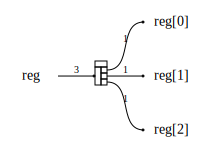

In [2]:
show_bloq(Split(QAny(3)))

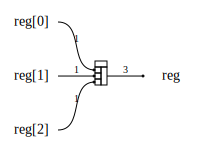

In [3]:
show_bloq(Join(QAny(3)))

## SplitJoin

For fun, we can pair `Split` and `Join` into an identity operation.

In [4]:
from attrs import frozen
from functools import cached_property
from typing import *
from qualtran import Bloq, Signature, Register
from qualtran.bloqs.basic_gates import CNOT

@frozen
class SplitJoin(Bloq):
    n: int

    @cached_property
    def signature(self) -> Signature:
        return Signature([Register('x', QAny(self.n))])

    def build_composite_bloq(
        self, bb: 'BloqBuilder', *, x: 'Soquet'
    ) -> Dict[str, 'Soquet']:
        xs = bb.split(x)
        xs[0], xs[1] = bb.add(CNOT(), ctrl=xs[0], target=xs[1])
        x = bb.join(xs)
        return {'x': x}

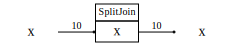

In [5]:
show_bloq(SplitJoin(10))

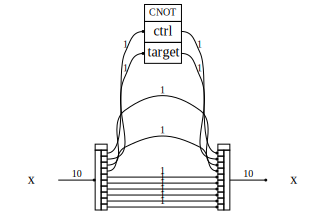

In [6]:
show_bloq(SplitJoin(10).decompose_bloq())

## Partition

A Partition is a useful bloq for abstracting away the details of large registers (like multiple selection registers, spin, orbital, ...). We can use a partition bloq to hide these detailed registers until we decompose the bloq further.

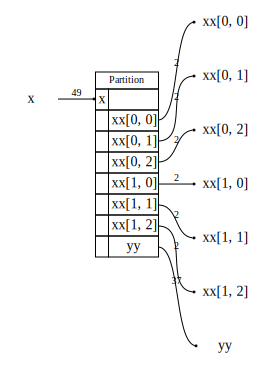

In [7]:
regs = (Register('xx', QAny(2), shape=(2,3)), Register('yy', QAny(37)))
bitsize = sum(reg.total_bits() for reg in regs)
bloq = Partition(n=bitsize, regs=regs)
show_bloq(bloq)

An example of using a `Partition` as part of a decomposition is given below:

In [8]:
from qualtran import BloqBuilder, Soquet, SoquetT
from qualtran.bloqs.for_testing import TestMultiRegister

@frozen
class BlackBoxBloq(Bloq):
    subbloq: Bloq

    @cached_property
    def bitsize(self):
        return sum(reg.total_bits() for reg in self.subbloq.signature)

    @cached_property
    def signature(self) -> Signature:
        return Signature.build(system=self.bitsize)

    def build_composite_bloq(self, bb: 'BloqBuilder', system: 'SoquetT') -> Dict[str, 'Soquet']:
        bloq_regs = self.subbloq.signature
        partition = Partition(self.bitsize, bloq_regs)
        partitioned_vars = bb.add(partition, x=system)
        partitioned_vars = bb.add(
            self.subbloq, **{reg.name: sp for reg, sp in zip(bloq_regs, partitioned_vars)}
        )
        system = bb.add(
            partition.adjoint(), **{reg.name: sp for reg, sp in zip(bloq_regs, partitioned_vars)}
        )
        return {'system': system}
    
    def short_name(self) -> str:
        return "BBBloq" 

As an example, we'll use the generic `TestMultiRegister` bloq as our sub-bloq with many registers. It does different (contrived) things to the `xx`, `yy`, and `zz` registers:

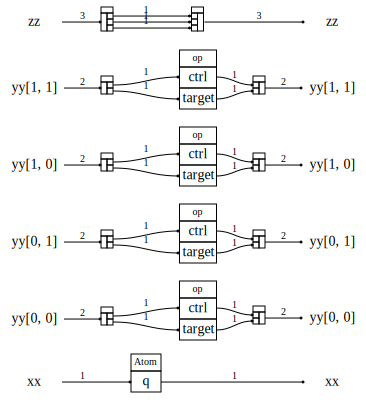

In [9]:
subbloq = TestMultiRegister()
show_bloq(subbloq.decompose_bloq())

By wrapping it in `BlackBoxBloq`, the previously-complicated signature is now just one register named "system" with a larger bitsize.

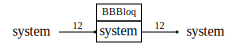

In [10]:
show_bloq(BlackBoxBloq(subbloq))

`Partition` adapts between the two register sets. We can inspect this in the decomposition:

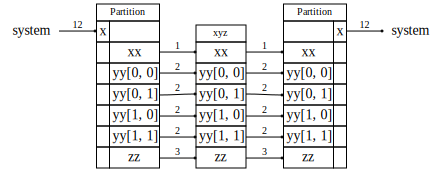

In [11]:
show_bloq(BlackBoxBloq(subbloq).decompose_bloq())

## Cast

Split, Joins and Partitions technically cast registers from one QDType to another. E.g. we can split an 32 QBit QInt register into an array of 32 QBits, and then join can be used to reinterpret this as a a different QDType (say a 32 bit QFxp). The Cast bloq cuts out the intermediate splits and joins and simply reinterprets n qubit registers.

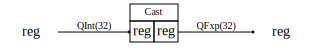

In [12]:
from qualtran import QInt, QFxp
from qualtran.bloqs.util_bloqs import Cast

show_bloq(Cast(QInt(32), QFxp(32, 32)), type='dtype')

This bloq is helpful if we want to explicitly cast registers from one type to another, which may be useful during a complex decomposition involving numeric registers.

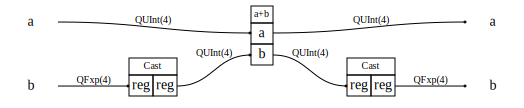

In [13]:
from qualtran.bloqs.for_testing import TestCastToFrom
show_bloq(TestCastToFrom().decompose_bloq(), type='dtype')

(<Figure size 626.087x800 with 1 Axes>, <Axes: >)

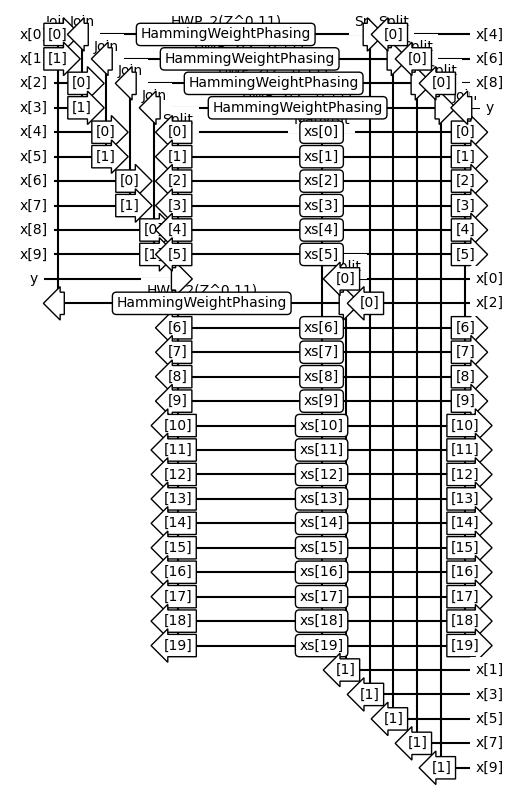

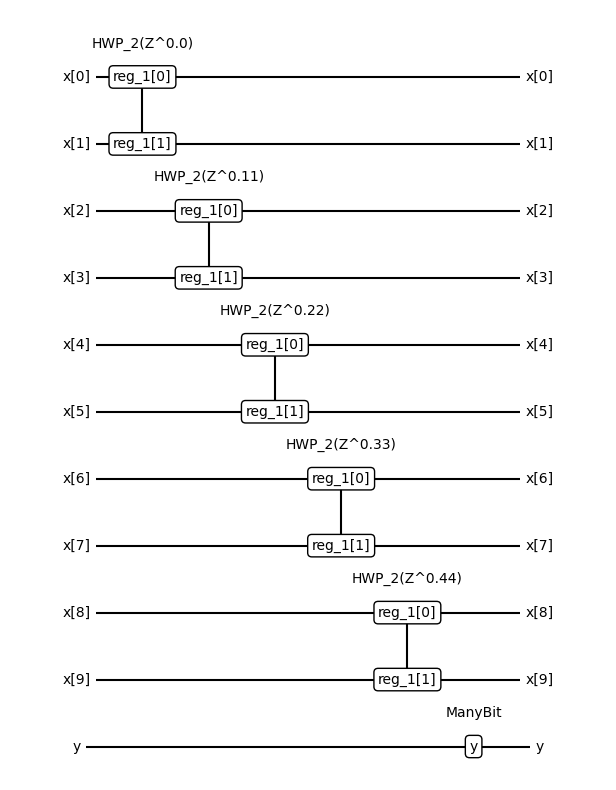

In [26]:
from qualtran import QBit, QUInt
from typing import Dict
from qualtran import BloqBuilder
from qualtran.bloqs.util_bloqs import Wrap
from qualtran.bloqs.rotations.hamming_weight_phasing import HammingWeightPhasing
from qualtran.drawing import draw_musical_score
from qualtran.drawing.musical_score import get_musical_score_data

@frozen
class ManyBit(Bloq):

    @cached_property
    def signature(self) -> Signature:
        return Signature((Register('xs', QBit(), shape=(20,)),))

@frozen
class NoWrap(Bloq):
    bitsize: int = 10

    @cached_property
    def signature(self) -> Signature:
        return Signature((Register('x', QBit(), shape=(self.bitsize,)), Register('y', QAny(20))))

    def build_composite_bloq(self, bb: BloqBuilder, x: 'SoquetT', y: 'SoquetT') -> Dict[str, 'SoquetT']:
        for i in range(5):
            two_bit = bb.join(x[i*2:i*2+2], QUInt(2))
            two_bit = bb.add(HammingWeightPhasing(2, 0.11), x=two_bit)
            x[i*2:i*2+2] = bb.split(two_bit)
        many_bit = bb.split(y)
        many_bit = bb.add(ManyBit(), xs=many_bit)
        return {'x': x, 'y': bb.join(many_bit)}

@frozen
class WithWrap(Bloq):
    bitsize: int = 10

    @cached_property
    def signature(self) -> Signature:
        return Signature((Register('x', QBit(), shape=(self.bitsize,)), Register('y', QAny(20))))

    def build_composite_bloq(self, bb: BloqBuilder, x: 'SoquetT', y: 'SoquetT') -> Dict[str, 'SoquetT']:
        for i in range(5):
            hwp =  HammingWeightPhasing(2, i*0.11)
            x[i*2:i*2+2] = bb.add(Wrap(hwp, (Register('reg_1', QBit(), shape=(2,)),), hwp.signature), reg_1=x[i*2:i*2+2])
        many = ManyBit()
        y = bb.add(Wrap(many, (self.signature.get_left('y'),), many.signature), y=y)
        return {'x': x, 'y': y}

bloq =  NoWrap()
draw_musical_score(get_musical_score_data(bloq.decompose_bloq()))
bloq =  WithWrap()
draw_musical_score(get_musical_score_data(bloq.decompose_bloq()))

(<Figure size 480x280 with 1 Axes>, <Axes: >)

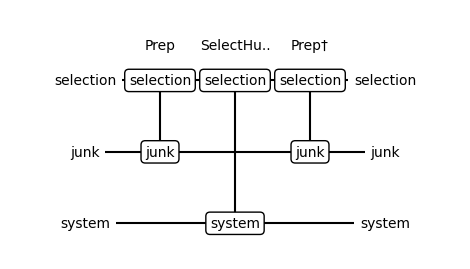

In [22]:
from qualtran.bloqs.hubbard_model import SelectHubbard, PrepareHubbard
from qualtran.bloqs.block_encoding import BlackBoxPrepare, BlackBoxSelect, BlackBoxBlockEncoding
dim = 4
# select = BlackBoxSelect(SelectHubbard(x_dim=dim, y_dim=dim))
sel_hubb = SelectHubbard(x_dim=dim, y_dim=dim)
sel = Register('selection', QAny(sum(r.bitsize for r in sel_hubb.selection_registers)))
sys = Register('system', QAny(sum(r.bitsize for r in sel_hubb.target_registers)))
select = Wrap(sel_hubb, outer_registers=(sel, sys), inner_registers=(sel_hubb.selection_registers, sel_hubb.target_registers))
prepare = BlackBoxPrepare(PrepareHubbard(x_dim=dim, y_dim=dim, t=1, mu=4))
black_box_block_bloq = BlackBoxBlockEncoding(select=select, prepare=prepare)
draw_musical_score(get_musical_score_data(black_box_block_bloq.decompose_bloq()))